## Environment

In [ ]:
import numpy as np

In [ ]:
class Environment():

  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost):
    self.n_arms = n_arms                                            # number of prices
    self.probabilities = probabilities                              # conversion rates for every price/arm
    self.bids = bids                                                # bids
    self.average_number_of_clicks = average_number_of_clicks        # curve of average number of clicks (y = f(bids))
    self.average_cum_daily_cost = average_cum_daily_cost            # curve of cumulative daily cost (y = g(bids))
    self.noise_clicks = noise_clicks                                # gaussian noise for the average number of clicks sampling
    self.noise_cost = noise_cost                                    # gaussian noise for the cumulative daily cost sampling

  # daily rewards
  def round(self, pulled_price, pulled_bid):
    reward_click = int(np.random.normal(self.average_number_of_clicks(bids[pulled_bid]),self.noise_clicks))  # number of people that click on the ad
    reward_price = np.random.binomial(reward_click,self.probabilities[pulled_price])                         # number of people that buy once they clicked
    reward_cost = np.random.normal(self.average_cum_daily_cost(bids[pulled_bid]),self.noise_cost)            # cumulative daily cost

    return reward_price, reward_click, reward_cost

## Pricing

In [ ]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [ ]:
class TS_Pricing_Learner(Learner): # Thompson-Sampling (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                    # number of prices
    self.beta_parameters = np.ones((n_arms,2))  # parameters of beta distributions
    self.prices = prices                        # prices (array)
    self.actual_reward = np.array([])           # storage of price*conversion_rate 

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    idx = np.argmax(np.random.beta(self.beta_parameters[:,0],self.beta_parameters[:,1])*self.prices)
    return idx

  # update parameters each time a reward (# of people that buy) is observed
  def update(self,pulled_arm, reward, n_clicks):
    self.t += 1
    self.update_observations(pulled_arm,reward)
    self.actual_reward = np.append(self.actual_reward, reward/n_clicks * self.prices[pulled_arm])
    self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
    self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + n_clicks - reward

In [ ]:
class UCB_Pricing_Learner(Learner): # UCB1 (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                              # number of arms/prices
    self.empirical_means = np.zeros(n_arms)               # mean reward for each arm (conversion rate)
    self.confidence = np.zeros(n_arms)                    # confidence bound for each arm
    self.prices = prices                                  # prices (array)
    self.n_clicks_per_arm = [[0] for i in range(n_arms)]  # number of total clicks for arm
    self.tot_n_clicks = 0                                 # cumulative number of clicks/rounds
    self.actual_reward = np.array([])                     # storage of price*conversion rate 

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    upper_bound = self.empirical_means + self.confidence
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    return pulled_arm

  def update(self, pulled_arm, reward, n_clicks):
    self.t += 1
    self.tot_n_clicks += n_clicks
    self.collected_rewards = np.append(self.collected_rewards, reward)
    self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]* np.sum(self.n_clicks_per_arm[pulled_arm]) + reward*self.prices[pulled_arm] ) / (np.sum(self.n_clicks_per_arm[pulled_arm]) + n_clicks)
    self.confidence[pulled_arm] = self.prices[pulled_arm]*np.sqrt(2*np.log(self.tot_n_clicks)/(np.sum(self.n_clicks_per_arm[pulled_arm]) + n_clicks))
    self.n_clicks_per_arm[pulled_arm].append(n_clicks)
    self.actual_reward = np.append(self.actual_reward, reward/n_clicks * self.prices[pulled_arm])
    self.update_observations(pulled_arm, reward)

## Advertising

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [ ]:
class GPTS_Learner(Learner):
  # constructor takes as input the number arms (bids), intializes to 0 their means and to an aye their standard deviation; we also need to store the arm that we pull at each round to fot the GPs
  def __init__(self, n_arms, arms):
    super().__init__(n_arms)
    self.arms = arms
    self.means_clicks = np.zeros(self.n_arms)
    self.means_costs = np.zeros(self.n_arms)
    self.sigmas_clicks = np.ones(self.n_arms) * 10
    self.sigmas_costs = np.ones(self.n_arms) * 10
    self.pulled_arms = []
    self.collected_clicks = []
    self.collected_costs = []
    # we initialize the parameters of the kernel and the two GPs
    alpha_clicks = 10  # standard deviation of the noise
    alpha_costs = 10   # standard deviation of the noise
    kernel_clicks = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3)) # kernel (squared exponential) with the range of the parameters
    kernel_costs = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))  # kernel (squared exponential) with the range of the parameters
    self.gp_clicks = GaussianProcessRegressor(kernel = kernel_clicks, alpha = alpha_clicks**2, n_restarts_optimizer = 10)  # (normalize_y = True)
    self.gp_costs = GaussianProcessRegressor(kernel = kernel_costs, alpha = alpha_costs**2, n_restarts_optimizer = 10)     # (normalize_y = True)

  # we also need to update the value of the least pulled arm (reward[0]: n_clicks, reward[1]: costs)
  def update_observations(self, arm_idx, reward):
    super().update_observations(arm_idx, reward)
    self.pulled_arms.append(self.arms[arm_idx])

  # update the GP estimations and consequently the means and sigmas of each arm
  def update_model(self):
    # trining inputs and targets
    x = np.atleast_2d(self.pulled_arms).T
    ind_clicks = [(2*i) for i in range(int(len(self.collected_rewards)/2)) ]
    ind_costs = [(2*i+1) for i in range(int(len(self.collected_rewards)/2)) ]
    y_clicks = self.collected_rewards[ind_clicks]
    y_costs = self.collected_rewards[ind_costs]
    # fit the GP
    self.gp_clicks.fit(x,y_clicks)
    self.gp_costs.fit(x,y_costs)
    # update values of means and sigmas with the new predictions
    self.means_clicks, self.sigmas_clicks = self.gp_clicks.predict(np.atleast_2d(self.arms).T, return_std = True)
    self.means_costs, self.sigmas_costs = self.gp_costs.predict(np.atleast_2d(self.arms).T, return_std = True)
    self.sigmas_clicks = np.maximum(self.sigmas_clicks, 1e-2)  # force sigmas > 0
    self.sigmas_costs = np.maximum(self.sigmas_costs, 1e-2)  # force sigmas > 0

  # functions that calls the functions implemented above (reward[0]: n_clicks, reward[1]: costs)
  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward)
    self.collected_clicks.append(reward[0])
    self.collected_costs.append(reward[1])
    self.update_model()

  # function in which the learner chooses the arm to pull at each round
  def pull_arm(self):
    # returns index of the maximum value drawn from the arm normal distribution
    sampled_clicks = np.random.normal(self.means_clicks, self.sigmas_clicks)
    sampled_costs = np.random.normal(self.means_costs, self.sigmas_costs)
    return np.argmax(sampled_clicks - sampled_costs)

## Simulation

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# generic
T = 365                                # horizon of experiment
n_experiments = 300                    # since the reward functions are stochastic, to better visualize the results and remove the noise we do multiple experiments

In [ ]:
# pricing
n_prices = 5
prices = [5,6,7,8,9]
p = np.array([0.15,0.1,0.1,0.35,0.1])             # bernoulli distributions for the reward functions
opt_rate = p[np.argmax(p*prices)]                 # optimal arm
print("Pricing (optimal price):")
print("idx: " + str(np.argmax(p*prices)) + "  price: " + str(prices[np.argmax(p*prices)]) + "  rate: " + str(opt_rate) + "  price*rate: " + str(opt_rate*prices[np.argmax(p*prices)]))

Pricing (optimal price):
idx: 3  price: 8  rate: 0.35  price*rate: 2.8


Advertising (optimal bid):
idx: 63  bid: 0.6363636363636365  clicks-costs: 13.820502035915808


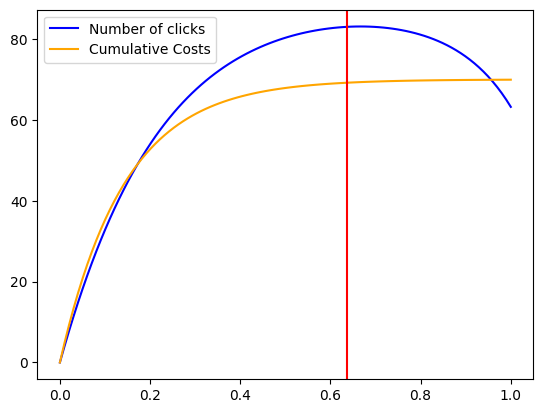

In [ ]:
# advertising
n_bids = 100
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_bids)
sigma_clicks = 10
sigma_costs = 10
def clicks(x):
  return 100 * (1.0 - np.exp(-4*x+3*x**3))
def costs(x):
  return 70 * (1.0 - np.exp(-7*x))
opt_bid = bids[np.argmax(clicks(bids)-costs(bids))]
fig, ax = plt.subplots()
ax.plot(bids,clicks(bids),'blue',bids,costs(bids),'orange')
ax.legend(["Number of clicks", "Cumulative Costs"])
ax.axvline(opt_bid,c='red')
print("Advertising (optimal bid):")
print("idx: " + str(np.argmax(clicks(bids)-costs(bids))) + "  bid: " + str(opt_bid) + "  clicks-costs: " + str(clicks(opt_bid)-costs(opt_bid)))

## Known advertising

In [ ]:
# experiments
ts_rewards_per_experiment = []
ucb_rewards_per_experiment = []

for e in tqdm(range(0,n_experiments)):  # cycle on experiments
  env = Environment(n_arms = n_prices,
                    probabilities = p,
                    bids = bids,
                    average_number_of_clicks = clicks,
                    average_cum_daily_cost = costs,
                    noise_clicks = sigma_clicks,
                    noise_cost = sigma_costs)
  ts_learner = TS_Pricing_Learner(n_arms = n_prices,
                                       prices = prices)
  ucb_learner = UCB_Pricing_Learner(n_arms = n_prices,
                                    prices = prices)


  ts_collected_clicks = np.array([])
  ts_collected_costs = np.array([])
  ucb_collected_clicks = np.array([])
  ucb_collected_costs = np.array([])

  for t in range(0,T):  # cycle on time horizon
    
    # TS
    pulled_price = ts_learner.pull_arm()
    pulled_bid = np.argmax(clicks(bids)-costs(bids))
    reward_price, reward_click, reward_cost = env.round(pulled_price,pulled_bid)
    ts_learner.update(pulled_price, reward_price, reward_click)

    ts_collected_clicks = np.append(ts_collected_clicks, reward_click)
    ts_collected_costs = np.append(ts_collected_costs, reward_cost)

    # UCB
    pulled_price = ucb_learner.pull_arm()
    pulled_bid = np.argmax(clicks(bids)-costs(bids))
    reward_price, reward_click, reward_cost = env.round(pulled_price,pulled_bid)
    ucb_learner.update(pulled_price, reward_price, reward_click)

    ucb_collected_clicks = np.append(ucb_collected_clicks, reward_click)
    ucb_collected_costs = np.append(ucb_collected_costs, reward_cost)

  ts_rewards_per_experiment.append(ts_learner.actual_reward*ts_collected_clicks - ts_collected_costs)
  ucb_rewards_per_experiment.append(ucb_learner.actual_reward*ucb_collected_clicks - ucb_collected_costs)

100%|██████████| 300/300 [00:43<00:00,  6.90it/s]


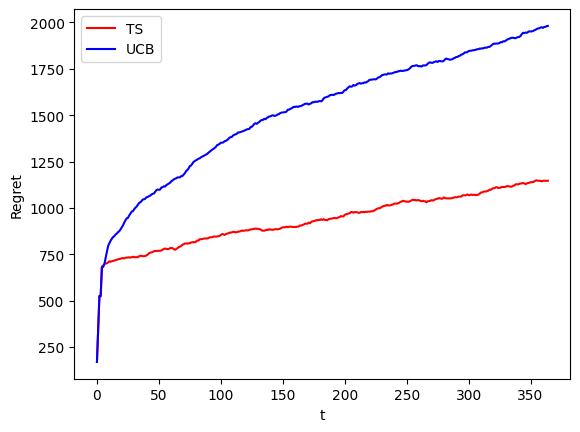

In [ ]:
opt = opt_rate*prices[np.argmax(p*prices)]*clicks(opt_bid) - costs(opt_bid)
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis = 0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis = 0)), 'b')
plt.legend(["TS", "UCB"])

## Unknown pricing and avertising

In [ ]:
# experiments
for e in tqdm(range(0,n_experiments)):  # cycle on experiments
  env = Environment(n_arms = n_prices,
                    probabilities = p,
                    bids = bids,
                    average_number_of_clicks = clicks,
                    average_cum_daily_cost = costs,
                    noise_clicks = sigma_clicks,
                    noise_cost = sigma_costs)
  pricing_learner = TS_Pricing_Learner(n_arms = n_prices,
                                       prices = prices)
  #advertising_learner = GPTS_Learner(n_arms = n_bids,
                                     arms = bids)

  for t in range(0,T):  # cycle on time horizon
    
    pulled_price = pricing_learner.pull_arm()
    pulled_bid = advertising_learner.pull_arm()
    reward_price, reward_click, reward_cost = env.round(pulled_price,pulled_bid)
    pricing_learner.update(pulled_price, reward_price, reward_click)
    advertising_learner.update(pulled_bid, [reward_click, reward_cost]) 

  rewards_per_experiment.append(pricing_learner.actual_reward*advertising_learner.collected_clicks - advertising_learner.collected_costs)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/g

KeyboardInterrupt: ignored